In [9]:
import numpy as np
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
%matplotlib inline

In [2]:
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [114]:
def get_unet(n_channels, n_classes):
    # Fully convolutional, we don't specify the image size
    inputs = Input((None, None, n_channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Bat
    #conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    #conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    #conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    #conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    #conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation=None)(conv9)  # outputs N density map, one for each type of sealion

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error', metrics=['accuracy', count_rmse])

    return model

In [115]:
def get_countnet(img_rows, img_cols, n_channels=3, n_classes=5):
    """ Regression network, output n_classes counts.
    :param img_rows: Height of the input image.
    :param img_cols: Width of the input image.
    :param n_channels: Number of channels in the input image (eg 3 for BGR)
    :param n_classes: Number of counts to output (eg 5, one for each type of sealion)
    """
    inputs = Input((img_rows, img_cols, n_channels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)   # (h/2, w/2, 32)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)   # (h/4, w/4, 64)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)   # (h/8, w/8, 128)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)   # (h/16, w/16, 128)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)   # (h/16, w/16, 512)
    
    avg = AveragePooling2D((7, 7))(conv5)   #(h/(16 * 7), w/(16 * 7), 512)
    avg = Flatten()(avg)
    
    hidden = Dense(128, activation='relu')(avg)
    count_regression = Dense(n_classes)(hidden)
    
    model = Model(inputs=[inputs], outputs=[count_regression])
    model.compile(optimizer=Adam(lr=1e-5), loss=mean_squared_error, metrics=[mean_squared_error])

    return model

In [116]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param x_mean: Mean per channel for input normalization
    :param x_std: Standard deviation per channel for input normalization
    :param y_scale: Scale to apply on the output density map
    :param output_counts: Indicate if the iterator should return only counts, otherwise density maps.
    :param n_samples_per_block: Number of patches to sample on each image.
    :param n_successive_samples: Number of samples to take on the same block when the block is loaded.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 5) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 x_mean, x_std, y_scale,
                 output_counts=False,
                 n_samples_per_block=12,
                 n_successive_samples=4,
                 target_size=(224, 224),
                 batch_size=8, shuffle=True, seed=42):
                 
        assert(n_samples_per_block % n_successive_samples == 0)
        assert(batch_size % n_successive_samples == 0)
        
        # Read the file containing the block status, ie if a block should be used or not
        with open(os.path.join(root_dir, "blocks_status.json"), "r") as jfile:
            blocks_status = json.load(jfile)
        
        # Fill with only valid blocks.
        self.image_ids = []
        self.block_ids = []
        for img_id in image_ids:
            blocks = blocks_status[str(img_id)]
            for bid, bstatus in enumerate(blocks):
                if bstatus:
                    self.image_ids.append(img_id)
                    self.block_ids.append(bid)
        
        self.x_mean = x_mean
        self.x_std = x_std
        self.y_scale = y_scale
        self.output_counts = output_counts
        self.root_dir = root_dir
        self.samples_per_block = n_samples_per_block
        self.n_successive_samples = n_successive_samples
        self.target_size = target_size
        self.n_blocks_per_batch = (n_samples_per_block // n_successive_samples)
        self.n_indices = len(self.image_ids) * self.n_blocks_per_batch
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size//self.n_successive_samples, shuffle, seed)
        
    def __normalize_input__(self, batch_x):
        return (batch_x - self.x_mean) / self.x_std
    
    def __normalize_output__(self, batch_y):
        return batch_y * self.y_scale
    
    def __normalize_sampling__(self, smap):
        w_edge = self.target_size[1]//2
        h_edge = self.target_size[0]//2
        # Set border to 0, it will avoid to deal with patches outside of the image
        smap[:, :w_edge] = 0
        smap[:, -w_edge:] = 0
        smap[:h_edge,:]=0
        smap[-h_edge:,:]=0
        # Normalize, to use it as a probability distribution
        return smap / np.sum(smap)

    def __sample__(self, img, dmap , smap, n):
        threshold_masked = 0.3 # if more than 30% of the patch is masked, reject it
        h, w, _ = img.shape
        pdistribution = self.__normalize_sampling__(smap).ravel()
        
        # There's a small risk that we can't find patches with enough non-masked pixels
        # so, we try several times (but we don't want to loop indefinitely)
        n_trys = 0
        i = 0
        while n_trys < 3:
            # Sample 10 * n random locations (we sample more because we may reject some)
            loc_indices = np.random.choice(h * w, size=(10 * n, ), replace=False, p=pdistribution)
            xs = np.zeros((n, ) + self.target_size + (3,))
            ys = np.zeros((n, ) + self.target_size + (5,))
            
            for loc_index in loc_indices:
                x = loc_index % w
                y = loc_index // w
                y_start = y - self.target_size[0] // 2
                y_end = y + self.target_size[0] // 2
                x_start = x - self.target_size[1] // 2
                x_end = x + self.target_size[1] // 2
                img_patch = img[y_start:y_end, x_start:x_end, :]
                masked_pixels = np.count_nonzero(img_patch == 0)
                total_pixels = img_patch.shape[0] * img_patch.shape[1]
                if masked_pixels/total_pixels < threshold_masked:
                    xs[i, ...] = img_patch
                    ys[i, ...] = dmap[y_start:y_end, x_start:x_end, :]
                    i += 1
                    if i == n:
                        return xs, ys
            n_trys += 1
        raise Exception("ERROR: Can't find non masked patches")
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        n = self.n_successive_samples
        batch_x = np.zeros((current_batch_size * n, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * n, 5)) if self.output_counts\
        else np.zeros((current_batch_size * n, self.target_size[0], self.target_size[1], 5), dtype=K.floatx())
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_blocks_per_batch
            image_id = self.image_ids[index]
            block_id = self.block_ids[index]
            uid = "{iid}_{bid}".format(iid=image_id, bid=block_id)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
            dmap = np.load(os.path.join(self.root_dir, "TrainDensity", uid + ".npz"))['dmap']
            smap = np.load(os.path.join(self.root_dir, "TrainSampling", uid + ".npz"))['smap']
            
            xs, ys = self.__sample__(img, dmap, smap, n)
            batch_x[i * n: (i + 1) * n,:,:,:] = xs
            if not self.output_counts: 
                batch_y[i * n: (i + 1) * n,:,:,:] = ys
            else:
                batch_y[i * n: (i + 1) * n,:] = np.sum(np.sum(ys, axis=1), axis=1)          

        return self.__normalize_input__(batch_x), self.__normalize_output__(batch_y)

In [117]:
mean_bgr = np.load("../data/sealion/mean_bgr.npy")
std_bgr = np.load("../data/sealion/std_bgr.npy")
patchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", [0, 1], mean_bgr, std_bgr, 1000)

In [118]:
for batch_x, batch_y in patchesGenerator:
    break

In [111]:
unet = get_unet(3, 5)

In [91]:
count_net = get_countnet(224, 224, 3, 5)

In [119]:
def count_rmse(y_true, y_pred):
    """ Compute the count rmse from the gt and predicted density map.
    :param y_true: Groundtruth density map, 4D tensor of shape (n_samples, height, width, types of sealion)
    :param y_pred: Predicted density map, 4D tensor of shape (n_samples, height, width, types of sealion)
    :return A Tensor of shape () (single value), with the RMSE(y_true, y_pred), averaged over the columns.
    """
    # shape is (n_samples, height, width, types of sealion)
    # we want to reduce it to (n_samples, types of sealion)
    # We don't round the counts, as it will be called on patches, with probably non-integer sum over the density map.
    counts_true = K.sum(K.sum(y_true, axis=1), axis=1)/1000
    counts_pred = K.sum(K.sum(y_pred, axis=1), axis=1)
    rmse_per_column = K.sqrt(K.mean(K.square(counts_pred - counts_true), axis=0))
    rmse = K.mean(rmse_per_column)
    return rmse

In [93]:
patchesCountsGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", [0, 1], mean_bgr, std_bgr, 1, output_counts=True)

In [120]:
h = unet.fit_generator(patchesGenerator, 10, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/1
10/10 [==============================] - 106s - loss: 0.0100 - acc: 0.1048 - count_rmse: 2219.2503    


In [95]:
h = count_net.fit_generator(patchesCountsGenerator, 10, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/1
10/10 [==============================] - 32s - loss: 2.1795 - mean_squared_error: 2.1795    


In [101]:
for batch_x, batch_y in patchesCountsGenerator:
    break

In [104]:
batch_ypred = count_net.predict(batch_x)

In [105]:
batch_ypred.shape

(8, 5)

In [106]:
batch_ypred

array([[ 0.04503033,  0.0214142 ,  0.07087332, -0.01858341,  0.01204333],
       [ 0.05483821,  0.02367533,  0.07683807, -0.02698153,  0.01134054],
       [ 0.03991929,  0.01652871,  0.05484734, -0.01835883,  0.01252967],
       [ 0.04658617,  0.02089278,  0.07013332, -0.02026835,  0.01366372],
       [ 0.05091123,  0.02374859,  0.07087958, -0.02539719,  0.0157924 ],
       [ 0.04172191,  0.01958505,  0.05661174, -0.01640396,  0.01240947],
       [ 0.10359951,  0.04887628,  0.15162231, -0.05763865,  0.01844923],
       [ 0.10366619,  0.04855519,  0.15165187, -0.05808643,  0.01841811]], dtype=float32)

In [107]:
batch_y

array([[  1.78632554e-17,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  9.96746150e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   4.57194338e-05,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  4.52876175e-11,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]])

In [37]:
def show_density(im, density):
    max_density = np.max(density)
    if max_density > 0:
        normalized_density = density/max_density
    else:
        normalized_density = density
    im_fp32 = im.astype(np.float32)
    im_masked = im_fp32.copy()
    im_masked[:,:,0] = (im_fp32[:,:,0] * normalized_density)
    im_masked[:,:,1] = (im_fp32[:,:,1] * normalized_density)
    im_masked[:,:,2] = (im_fp32[:,:,2] * normalized_density)
    return im_masked.astype(np.uint8), (normalized_density * 255).astype(np.uint8)

In [78]:
for i, (x, y) in enumerate(zip(batch_x, batch_y)):
    im, mask = show_density(x, y[:,:,2])
    cv2.imwrite("../data/dmap" + str(i) + ".png", mask)

In [89]:
np.mean(batch_y)

0.0021947357

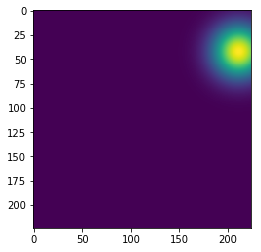

In [79]:
plt.imshow(batch_y[0,:,:,2])

In [86]:
np.mean(np.abs(batch_ypred))

0.078324102

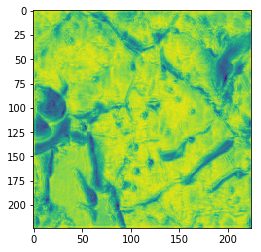

In [81]:
plt.imshow(batch_ypred[0,:,:,2])

In [108]:
batch_y[0,50:75,50:100,2]

IndexError: too many indices for array

In [82]:
with sess.as_default():
    print(np.mean(mean_squared_error(batch_y, batch_ypred).eval()))

0.0146002
